# WEST IC C5 Conditioning Campaign 

In [1]:
%matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
import matplotlib.dates as mdates
import datetime

In [9]:
import seaborn as sns

# Creating the database

In [3]:
def read_conditoning_data(filename):
    """
    Import and return the ICRH Conditioning data into a pandas DataFrame
    """

    data = pd.read_csv(filename, delimiter='\t', skiprows=18, 
                names=('Temps',
                       'PiG','PrG','PiD','PrD',
                       'V1','V2','V3','V4', 
                       'Ph(V1-V3)','Ph(V2-V4)',
                       'Consigne_mes', 'Vide_gauche', 'Vide_droit',
                       'reserve1', 'reserve2', '_'),
                index_col='Temps') # last element '_' to avoid pandas crashing
    # convert phase in degree and wrap it between 0° and 359°
    data['Ph(V1-V3)'] /= 100
    data['Ph(V2-V4)'] /= 100
    #data['Ph(V1-V3)'] %= 360
    #data['Ph(V2-V4)'] %= 360
    return data 

def read_conditioning_metadata(filename):
    """
    Import and return the ICRH Conditioning metadata into a dictionary
    """
    para_dic = {}
    with  open(filename,'r') as cmt_file:    # open file
        for line in cmt_file:    # read each line
            if line[0] == '#':    # check the first character
                line = line[1:]    # remove first '#'
                para = line.split('=')     # seperate string by '='
                if len(para) == 2:
                    para_dic[ para[0].strip()] = para[1].strip()
    return para_dic 

In [57]:
file = 'Conditionning/2020-12-01_09-37-26.csv'
'''
Get the metadata of a file and generate a pandas DataFrame of them
'''
def forge_df(file):
    metadata = read_conditioning_metadata(file)
    _datetime = pd.datetime.strptime(metadata['Date']+' '+metadata['Heure'], '%Y-%m-%d %H-%M-%S')
    _row = pd.DataFrame(data={'Date':_datetime, 
                       'Antenna':int(metadata['Antenne'][1]), 
                       'Duration':float(metadata['Duree du tir'].split()[0]),
                       'Frequency':float(metadata['Frequence'].split()[0]),
                       'Nb of Vr/Vi':int(metadata['Nb interruptions TOS']),
                       'Nb of SHAD': int(metadata['Nb interruptions SHAD']),
                       'Nb of Optical':int(metadata['Nb interruptions OPT']),
                       'Nb total': int(metadata['Nb interruptions TOTAL']),
                       'Vacuum stop': int(metadata['Arret sur defaut vide'])
                      }, index=[0])#.set_index('Date')

    # pass for empty pulses 
    try:
        _all_data = read_conditoning_data(file)
        # calculation real pulse duration
        t_start = _all_data.query('V1 > 1500 or V2 > 1500 or V3 > 1500 or V4 > 1500').index[0]
        t_stop = _all_data.query('V1 > 1500 or V2 > 1500 or V3 > 1500 or V4 > 1500').index[-1]
        duration = (t_stop - t_start)/1e6  # s
        
        # keep only max values of each columns
        _data_max = _all_data.max().to_frame().T
        # power must be divided by 10 to get kW and divided by 2 as it correspond to total power 
        _data_max['PiG'] = _data_max['PiG']/10/2
        _data_max['PiD'] = _data_max['PiD']/10/2     
        # Max Energy
        _data_max['Energie_Left'] = np.trapz(_data_max.PiG*1e3, _data_max.index/1e6)
        _data_max['Energie_Right'] = np.trapz(_data_max.PiD*1e3, _data_max.index/1e6)
        
        _data_max.columns = [colname+'_max' for colname in _data_max.columns]
        
        # mean values during RF pulse
        _data_mean = _all_data.query('index >= @t_start and index <= @t_stop').mean().to_frame().T
        # power must be divided by 10 to get kW and divided by 2 as it correspond to total power 
        _data_mean['PiG'] = _data_mean['PiG']/10/2
        _data_mean['PiD'] = _data_mean['PiD']/10/2     
        # Mean Energy
        _data_mean['Energie_Left'] = np.trapz(_data_mean.PiG*1e3, _data_mean.index/1e6)
        _data_mean['Energie_Right'] = np.trapz(_data_mean.PiD*1e3, _data_mean.index/1e6)
        
        _data_mean.columns = [colname+'_mean' for colname in _data_mean.columns]
               
        # final data
        _row_final = pd.concat([_data_max, _data_mean, _row], axis=1)
        _row_final.set_index('Date')
        _row_final['Duration_'] = duration   
        
    except IndexError:
        _row_final = None
   
    return _row_final

In [58]:
files = glob('../WEST_C4/Conditionning/2019*.csv')

df = pd.DataFrame()
for file in tqdm(files):
    df=df.append(forge_df(file))
df2019=df.set_index('Date')


  0%|                                                                                         | 0/1148 [00:00<?, ?it/s]C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys
100%|██████████████████████████████████████████████████████████████████████████████| 1148/1148 [00:32<00:00, 35.70it/s]


In [59]:
files = glob('Conditionning/2020*.csv')

df = pd.DataFrame()
for file in tqdm(files):
    df=df.append(forge_df(file))
df2020=df.set_index('Date')


  0%|                                                                                          | 0/924 [00:00<?, ?it/s]C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys
100%|████████████████████████████████████████████████████████████████████████████████| 924/924 [00:30<00:00, 30.43it/s]


In [60]:
# merge 2019 and 2020 data
df = pd.concat([df2019, df2020])

In [61]:
df.columns

Index(['PiG_max', 'PrG_max', 'PiD_max', 'PrD_max', 'V1_max', 'V2_max',
       'V3_max', 'V4_max', 'Ph(V1-V3)_max', 'Ph(V2-V4)_max',
       'Consigne_mes_max', 'Vide_gauche_max', 'Vide_droit_max', 'reserve1_max',
       'reserve2_max', '__max', 'Energie_Left_max', 'Energie_Right_max',
       'PiG_mean', 'PrG_mean', 'PiD_mean', 'PrD_mean', 'V1_mean', 'V2_mean',
       'V3_mean', 'V4_mean', 'Ph(V1-V3)_mean', 'Ph(V2-V4)_mean',
       'Consigne_mes_mean', 'Vide_gauche_mean', 'Vide_droit_mean',
       'reserve1_mean', 'reserve2_mean', '__mean', 'Energie_Left_mean',
       'Energie_Right_mean', 'Antenna', 'Duration', 'Frequency', 'Nb of Vr/Vi',
       'Nb of SHAD', 'Nb of Optical', 'Nb total', 'Vacuum stop', 'Duration_'],
      dtype='object')

In [130]:
df['V_max'] = df[['V1_max','V2_max', 'V3_max', 'V4_max']].max(axis=1)/1e3
df['P_max'] = df['PiD_max'] + df['PiG_max']
df['V_mean'] = df[['V1_mean','V2_mean', 'V3_mean', 'V4_mean']].max(axis=1)/1e3
df['P_mean'] = df['PiD_mean'] + df['PiG_mean']


# df['pressure_gauche'] = np.power(10, 1.667*df.Vide_gauche*1e-3 - 9.33)
# df['pressure_droit'] = np.power(10, 1.667*df.Vide_droit*1e-3 - 9.33)
# df['pressure_max'] = df[['pressure_gauche', 'pressure_droit']].max(axis=1)

df['year'] = pd.to_datetime(df.index).year
df['day'] = pd.to_datetime(df.index).day

# Ploting the results

# Duration vs date

### Q4 - 2019

<IPython.core.display.Javascript object>


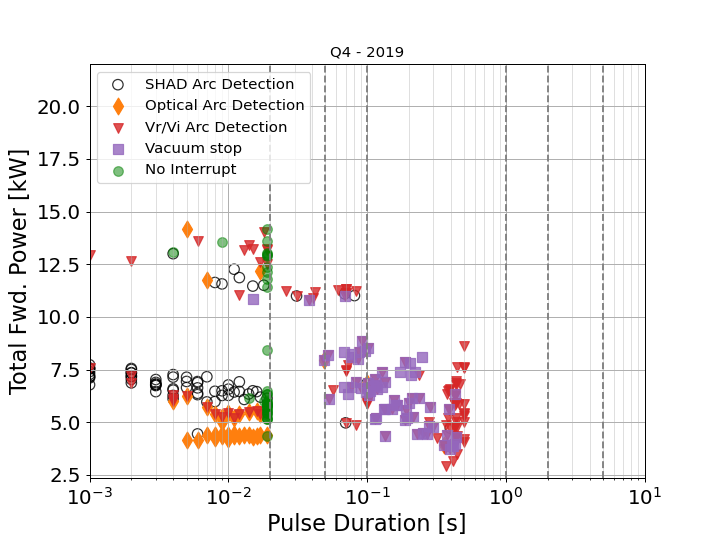

In [65]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [4] and year == 2019')
ax.scatter(_df['Duration_'][_df['Nb of SHAD'] > 0], _df['P_mean'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Optical'] > 0], _df['P_mean'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Vr/Vi'] > 0], _df['P_mean'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['Duration_'][_df['Vacuum stop'] > 0], _df['P_mean'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop` == 0 and `Nb total` == 0 ")
ax.scatter(_df_nostop['Duration_'], _df_nostop['P_mean'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

ax.set_xscale('log')
ax.set_xlim(left=1e-3, right=6)
# ax.set_yscale('log')
ax.set_ylim(top=22)  # half-side only
ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_xlabel('Pulse Duration [s]', fontsize=18)
ax.set_ylabel('Total Fwd. Power [kW]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q4 - 2019')
for target_duration in [0.02, 0.05, 0.1, 1, 2, 5]:
    ax.axvline(target_duration, color='gray', ls='--', label='target')

<IPython.core.display.Javascript object>


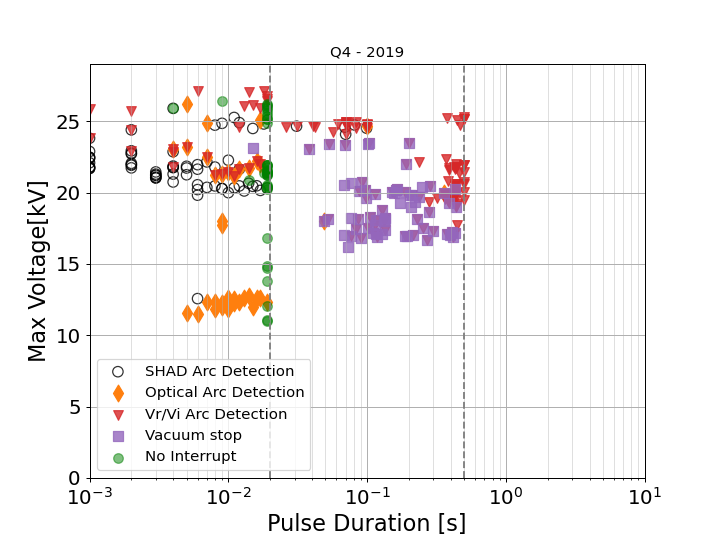

In [71]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [4] and year == 2019')
ax.scatter(_df['Duration_'][_df['Nb of SHAD'] > 0], _df['V_max'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Optical'] > 0], _df['V_max'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Vr/Vi'] > 0], _df['V_max'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['Duration_'][_df['Vacuum stop'] > 0], _df['V_max'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop` == 0 and `Nb total` == 0 ")
ax.scatter(_df_nostop['Duration_'], _df_nostop['V_max'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

ax.set_xscale('log')
ax.set_xlim(left=1e-3, right=6)
ax.set_ylim(0, 29)
ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_xlabel('Pulse Duration [s]', fontsize=18)
ax.set_ylabel('Max Voltage[kV]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q4 - 2019')
for target_duration in [0.02, 0.5]:
    ax.axvline(target_duration, color='gray', ls='--', label='target')

<IPython.core.display.Javascript object>


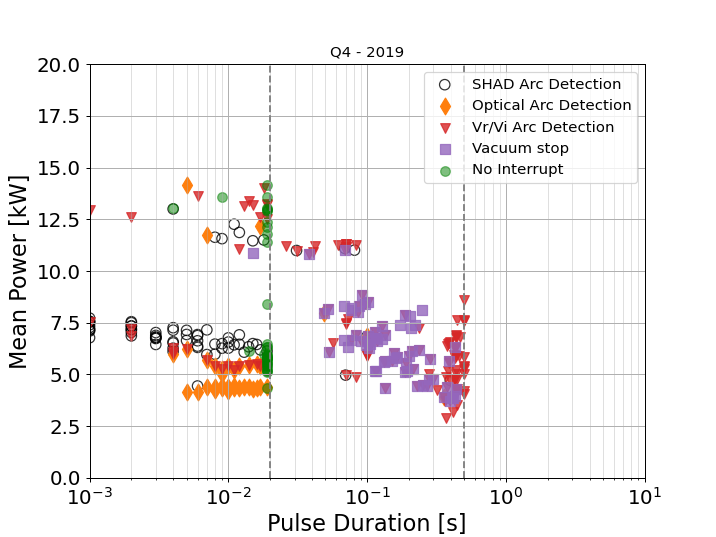

In [74]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [4] and year == 2019')
ax.scatter(_df['Duration_'][_df['Nb of SHAD'] > 0], _df['P_mean'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Optical'] > 0], _df['P_mean'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Vr/Vi'] > 0], _df['P_mean'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['Duration_'][_df['Vacuum stop'] > 0], _df['P_mean'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop` == 0 and `Nb total` == 0 ")
ax.scatter(_df_nostop['Duration_'], _df_nostop['P_mean'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

ax.set_xscale('log')
ax.set_xlim(left=1e-3, right=6)
ax.set_ylim(0, 20)
ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_xlabel('Pulse Duration [s]', fontsize=18)
ax.set_ylabel('Mean Power [kW]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q4 - 2019')
for target_duration in [0.02, 0.5]:
    ax.axvline(target_duration, color='gray', ls='--', label='target')

<IPython.core.display.Javascript object>


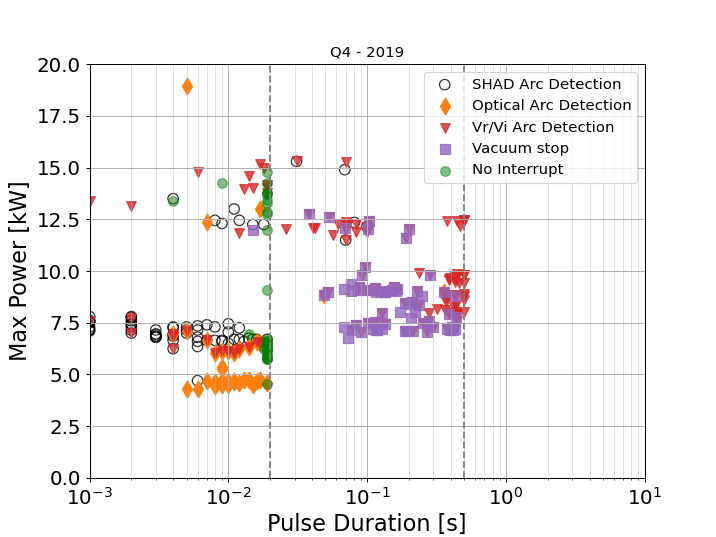

In [75]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [4] and year == 2019')
ax.scatter(_df['Duration_'][_df['Nb of SHAD'] > 0], _df['P_max'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Optical'] > 0], _df['P_max'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Vr/Vi'] > 0], _df['P_max'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['Duration_'][_df['Vacuum stop'] > 0], _df['P_max'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop` == 0 and `Nb total` == 0 ")
ax.scatter(_df_nostop['Duration_'], _df_nostop['P_max'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

ax.set_xscale('log')
ax.set_xlim(left=1e-3, right=6)
ax.set_ylim(0, 20)
ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_xlabel('Pulse Duration [s]', fontsize=18)
ax.set_ylabel('Max Power [kW]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q4 - 2019')
for target_duration in [0.02, 0.5]:
    ax.axvline(target_duration, color='gray', ls='--', label='target')

### Q1 - 2020

<IPython.core.display.Javascript object>


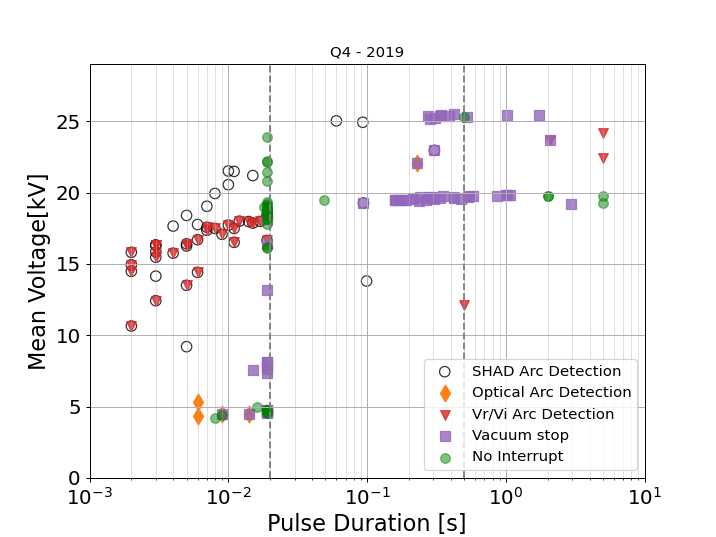

In [76]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [1] and year == 2020')
ax.scatter(_df['Duration_'][_df['Nb of SHAD'] > 0], _df['V_mean'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Optical'] > 0], _df['V_mean'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Vr/Vi'] > 0], _df['V_mean'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['Duration_'][_df['Vacuum stop'] > 0], _df['V_mean'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop` == 0 and `Nb total` == 0 ")
ax.scatter(_df_nostop['Duration_'], _df_nostop['V_mean'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

ax.set_xscale('log')
ax.set_xlim(left=1e-3, right=6)
ax.set_ylim(0, 29)
ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_xlabel('Pulse Duration [s]', fontsize=18)
ax.set_ylabel('Mean Voltage[kV]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q4 - 2019')
for target_duration in [0.02, 0.5]:
    ax.axvline(target_duration, color='gray', ls='--', label='target')

<IPython.core.display.Javascript object>


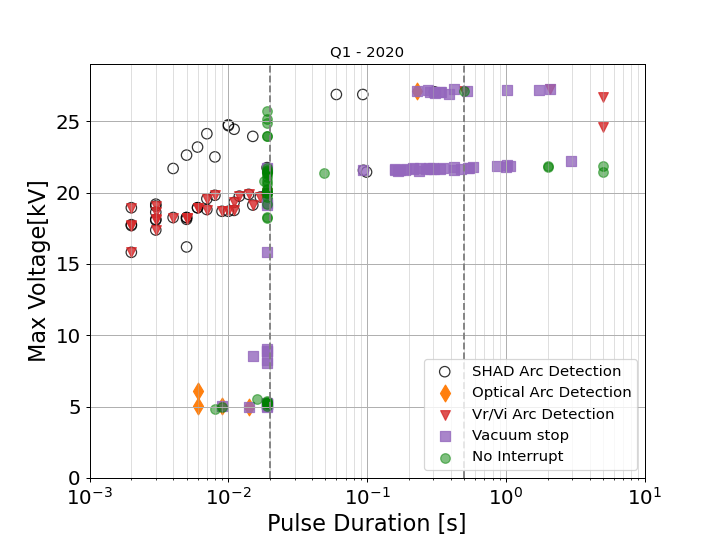

In [200]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [1] and year == 2020')
ax.scatter(_df['Duration_'][_df['Nb of SHAD'] > 0], _df['V_max'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Optical'] > 0], _df['V_max'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Vr/Vi'] > 0], _df['V_max'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['Duration_'][_df['Vacuum stop'] > 0], _df['V_max'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop` == 0 and `Nb total` == 0 ")
ax.scatter(_df_nostop['Duration_'], _df_nostop['V_max'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

ax.set_xscale('log')
ax.set_xlim(left=1e-3, right=6)
ax.set_ylim(0, 29)
ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_xlabel('Pulse Duration [s]', fontsize=18)
ax.set_ylabel('Max Voltage[kV]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q1 - 2020')
for target_duration in [0.02, 0.5]:
    ax.axvline(target_duration, color='gray', ls='--', label='target')

<IPython.core.display.Javascript object>


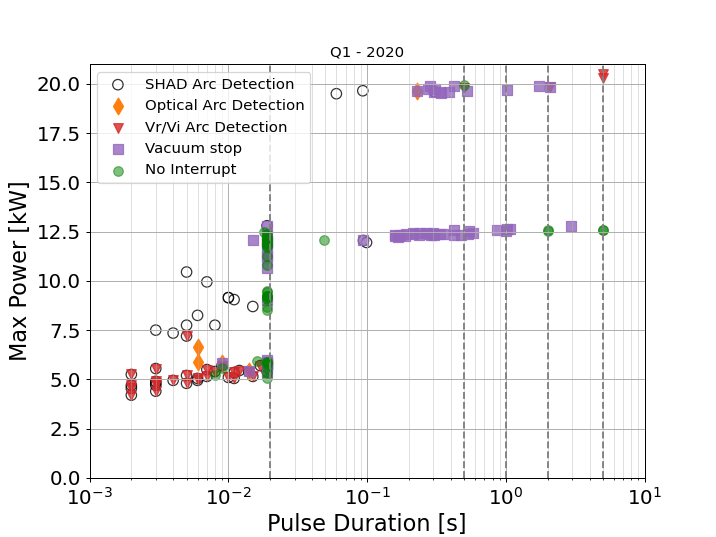

In [210]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [1] and year == 2020')
ax.scatter(_df['Duration_'][_df['Nb of SHAD'] > 0], _df['P_max'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Optical'] > 0], _df['P_max'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Vr/Vi'] > 0], _df['P_max'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['Duration_'][_df['Vacuum stop'] > 0], _df['P_max'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop` == 0 and `Nb total` == 0 ")
ax.scatter(_df_nostop['Duration_'], _df_nostop['P_max'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

ax.set_xscale('log')
ax.set_xlim(left=1e-3, right=6)
ax.set_ylim(0, 21)
ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_xlabel('Pulse Duration [s]', fontsize=18)
ax.set_ylabel('Max Power [kW]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q1 - 2020')
for target_duration in [0.02,  0.5, 1, 2, 5]:
    ax.axvline(target_duration, color='gray', ls='--', label='target')

<IPython.core.display.Javascript object>


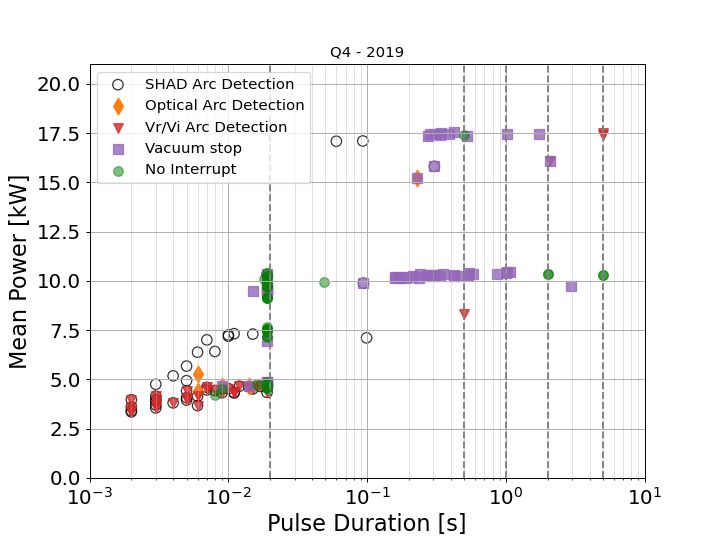

In [91]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [1] and year == 2020')
ax.scatter(_df['Duration_'][_df['Nb of SHAD'] > 0], _df['P_mean'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Optical'] > 0], _df['P_mean'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Vr/Vi'] > 0], _df['P_mean'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['Duration_'][_df['Vacuum stop'] > 0], _df['P_mean'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop` == 0 and `Nb total` == 0 ")
ax.scatter(_df_nostop['Duration_'], _df_nostop['P_mean'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

ax.set_xscale('log')
ax.set_xlim(left=1e-3, right=6)
ax.set_ylim(0, 21)
ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_xlabel('Pulse Duration [s]', fontsize=18)
ax.set_ylabel('Mean Power [kW]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q4 - 2019')
for target_duration in [0.02,  0.5, 1, 2, 5]:
    ax.axvline(target_duration, color='gray', ls='--', label='target')

### Chronologie

<IPython.core.display.Javascript object>


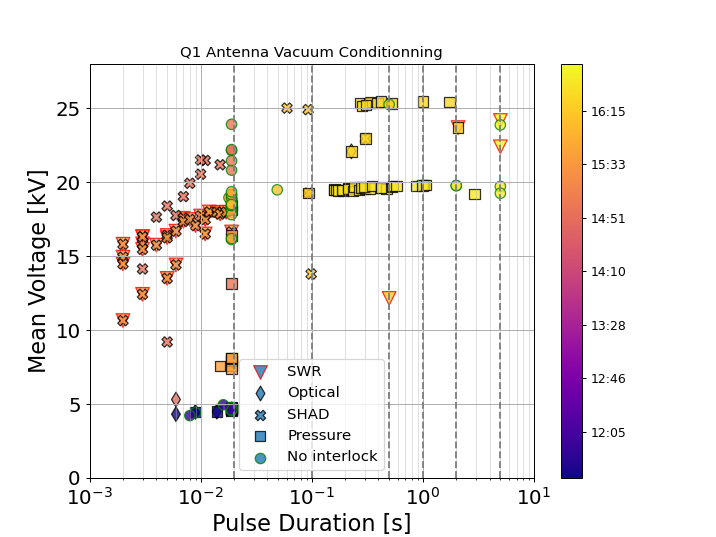

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [209]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [1] and year == 2020')

# Interlock type booleans
_df['SWR'] = _df['Nb of Vr/Vi'] > 0
_df['optical'] = _df['Nb of Optical'] > 0
_df['SHAD'] = _df['Nb of SHAD'] > 0
_df['pressure'] = _df['Vacuum stop'] > 0
_df['date'] = pd.to_datetime(_df.index)

_min = _df['date'].min().value
_max = _df['date'].max().value
_norm = plt.Normalize(vmin=_min, vmax=_max)
_cmap = 'plasma'
sm = plt.cm.ScalarMappable(cmap=_cmap, norm=_norm)

_df_ = _df.query(' SWR == True')
ax.scatter(x=_df_['Duration_'], y=_df_['V_mean'], c=_df_['date'],
    alpha=.8, marker='v', edgecolor='r', s=120, norm=_norm, label='SWR', cmap=_cmap)

_df_ = _df.query('optical == True')
ax.scatter(x=_df_['Duration_'], y=_df_['V_mean'], c=_df_['date'],
    alpha=.8, marker='d', edgecolor='k', s=70, norm=_norm, label='Optical', cmap=_cmap)

_df_ = _df.query('SHAD == True')
ax.scatter(x=_df_['Duration_'], y=_df_['V_mean'], c=_df_['date'],
    alpha=.8, marker='X', edgecolor='k', s=70, norm=_norm, label='SHAD', cmap=_cmap)

_df_ = _df.query('pressure == True')
ax.scatter(x=_df_['Duration_'], y=_df_['V_mean'], c=_df_['date'],
    alpha=.8, marker='s', edgecolor='k', s=70, norm=_norm, label='Pressure', cmap=_cmap)

_df_ = _df.query(' SWR == False and optical == False and SHAD == False and pressure == False')
ax.scatter(x=_df_['Duration_'], y=_df_['V_mean'], c=_df_['date'],
    alpha=.8, marker='o', edgecolor='g', s=70, norm=_norm, label='No interlock', cmap=_cmap)

cbar = plt.colorbar(sm)
# Change the numeric ticks into ones that match the x-axis
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%H:%M'))


ax.set_xscale('log')
ax.set_xlim(left=1e-3, right=6)
ax.set_ylim(0, 28)
ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_xlabel('Pulse Duration [s]', fontsize=18)
ax.set_ylabel('Mean Voltage [kV]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q1 Antenna Vacuum Conditionning')
for target_duration in [0.02,  0.1, 0.5, 1, 2, 5]:
    ax.axvline(target_duration, color='gray', ls='--', label='target')

<IPython.core.display.Javascript object>


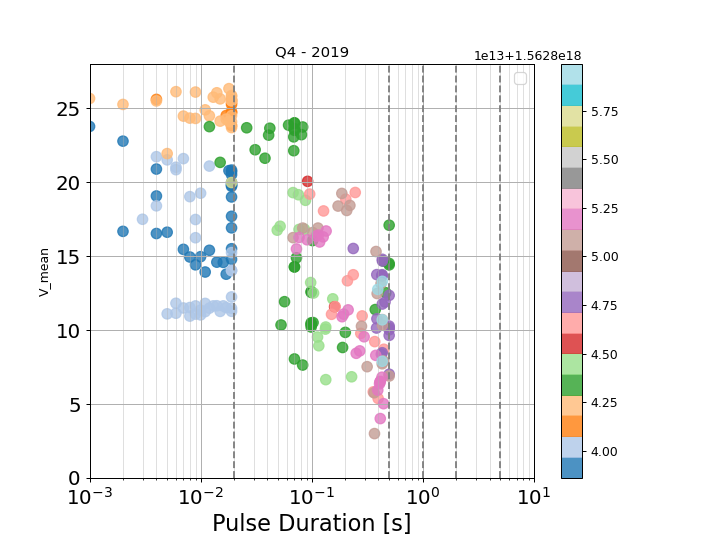

No handles with labels found to put in legend.


In [137]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [4] and year == 2019 and day > 10')
_df.plot(kind='scatter', ax=ax, x='Duration_', y='V_mean', alpha=.8, marker='o', color=_df.reset_index()['Date'], s=70,
        cmap='tab20', colorbar=True)

ax.set_xscale('log')
ax.set_xlim(left=1e-3, right=6)
ax.set_ylim(0, 28)
ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_xlabel('Pulse Duration [s]', fontsize=18)
# ax.set_ylabel('Mean Power [kW]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q4 - 2019')
for target_duration in [0.02,  0.5, 1, 2, 5]:
    ax.axvline(target_duration, color='gray', ls='--', label='target')

<IPython.core.display.Javascript object>


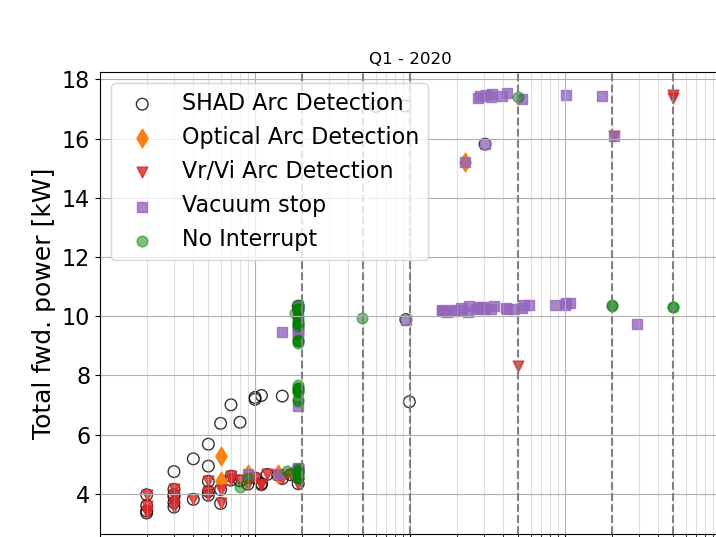

NameError: name 'fig' is not defined

In [39]:
fix, ax = plt.subplots(figsize=(8,6))
_df = df.query('Duration_>0 and Antenna == [1] and year == 2020')
ax.scatter(_df['Duration_'][_df['Nb of SHAD'] > 0], _df['P_tot'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Optical'] > 0], _df['P_tot'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Vr/Vi'] > 0], _df['P_tot'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['Duration_'][_df['Vacuum stop'] > 0], _df['P_tot'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop`  ==0 and `Nb total` ==0 ")
ax.scatter(_df_nostop['Duration_'], _df_nostop['P_tot'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

ax.set_xscale('log')
ax.set_xlim(left=1e-3, right=6)
# ax.set_yscale('log')
# ax.set_ylim(top=15)  # half-side only
ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_xlabel('Pulse Duration [s]', fontsize=18)
ax.set_ylabel('Total fwd. power [kW]', fontsize=18)
ax.legend(fontsize=16)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q1 - 2020')

for target_duration in [0.02, 0.05, 0.1, 0.5, 2, 5]:
    ax.axvline(target_duration, color='gray', ls='--', label='target')
fig.tight_layout()

In [131]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [1] and year == 2020')
ax.scatter(_df['Duration_'][_df['Nb of SHAD'] > 0], _df['V_max'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Optical'] > 0], _df['V_max'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Vr/Vi'] > 0], _df['V_max'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['Duration_'][_df['Vacuum stop'] > 0], _df['V_max'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop`  ==0 and `Nb total` ==0 ")
ax.scatter(_df_nostop['Duration_'], _df_nostop['V_max'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

ax.set_xscale('log')
ax.set_xlim(left=1e-3, right=6)
# ax.set_yscale('log')
# ax.set_ylim(top=15)  # half-side only
ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_xlabel('Pulse Duration [s]', fontsize=18)
ax.set_ylabel('Mean Voltage [kV]', fontsize=18)
ax.legend(fontsize=16)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q1 - 2020')

for target_duration in [0.02, 0.05, 0.1, 0.5, 2, 5]:
    ax.axvline(target_duration, color='gray', ls='--', label='target')
fig.tight_layout()

<IPython.core.display.Javascript object>

NameError: name 'fig' is not defined

In [ ]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [1] and year == 2020')
ax.scatter(_df['P_tot'][_df['Nb of SHAD'] > 0], _df['V_max'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['P_tot'][_df['Nb of Optical'] > 0], _df['V_max'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['P_tot'][_df['Nb of Vr/Vi'] > 0], _df['V_max'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['P_tot'][_df['Vacuum stop'] > 0], _df['V_max'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop`  ==0 and `Nb total` ==0 ")
ax.scatter(_df_nostop['P_tot'], _df_nostop['V_max'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

# ax.set_xscale('log')
# ax.set_xlim(left=1e-3, right=6)
# ax.set_yscale('log')
# ax.set_ylim(top=15)  # half-side only
# ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_ylabel('Max Voltage [V]', fontsize=18)
ax.set_xlabel('Fwd. Power [kW]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q1 - 2020')

fig.tight_layout()

In [ ]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [4] and year == 2019')
ax.scatter(_df['P_tot'][_df['Nb of SHAD'] > 0], _df['V_max'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['P_tot'][_df['Nb of Optical'] > 0], _df['V_max'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['P_tot'][_df['Nb of Vr/Vi'] > 0], _df['V_max'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['P_tot'][_df['Vacuum stop'] > 0], _df['V_max'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop`  ==0 and `Nb total` ==0 ")
ax.scatter(_df_nostop['P_tot'], _df_nostop['V_max'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

# ax.set_xscale('log')
# ax.set_xlim(left=1e-3, right=6)
# ax.set_yscale('log')
# ax.set_ylim(top=15)  # half-side only
# ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_ylabel('Max Voltage [V]', fontsize=18)
ax.set_xlabel('Fwd. Power [kW]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q4 - 2019')

fig.tight_layout()

In [ ]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [1] and year == 2019')
ax.scatter(_df['P_tot'][_df['Nb of SHAD'] > 0], _df['V_max'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['P_tot'][_df['Nb of Optical'] > 0], _df['V_max'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['P_tot'][_df['Nb of Vr/Vi'] > 0], _df['V_max'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['P_tot'][_df['Vacuum stop'] > 0], _df['V_max'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop`  ==0 and `Nb total` ==0 ")
ax.scatter(_df_nostop['P_tot'], _df_nostop['V_max'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

# ax.set_xscale('log')
# ax.set_xlim(left=1e-3, right=6)
# ax.set_yscale('log')
# ax.set_ylim(top=15)  # half-side only
# ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_ylabel('Max Voltage [V]', fontsize=18)
ax.set_xlabel('Fwd. Power [kW]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q1 - 2019')

fig.tight_layout()

In [ ]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [2] and year == 2019')
ax.scatter(_df['P_tot'][_df['Nb of SHAD'] > 0], _df['V_max'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['P_tot'][_df['Nb of Optical'] > 0], _df['V_max'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['P_tot'][_df['Nb of Vr/Vi'] > 0], _df['V_max'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['P_tot'][_df['Vacuum stop'] > 0], _df['V_max'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop`  ==0 and `Nb total` ==0 ")
ax.scatter(_df_nostop['P_tot'], _df_nostop['V_max'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

# ax.set_xscale('log')
# ax.set_xlim(left=1e-3, right=6)
# ax.set_yscale('log')
# ax.set_ylim(top=15)  # half-side only
# ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_ylabel('Max Voltage [V]', fontsize=18)
ax.set_xlabel('Fwd. Power [kW]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q2 - 2019')

fig.tight_layout()

In [ ]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [1] and year == 2020')
ax.scatter(_df['P_tot'][_df['Nb of SHAD'] > 0], _df['V_max'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['P_tot'][_df['Nb of Optical'] > 0], _df['V_max'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['P_tot'][_df['Nb of Vr/Vi'] > 0], _df['V_max'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['P_tot'][_df['Vacuum stop'] > 0], _df['V_max'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop`  ==0 and `Nb total` ==0 ")
ax.scatter(_df_nostop['P_tot'], _df_nostop['V_max'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

# ax.set_xscale('log')
# ax.set_xlim(left=1e-3, right=6)
# ax.set_yscale('log')
# ax.set_ylim(top=15)  # half-side only
# ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_ylabel('Max Voltage [V]', fontsize=18)
ax.set_xlabel('Fwd. Power [kW]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q1 - 2020')

fig.tight_layout()

In [ ]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [2] and year == 2019')
ax.scatter(_df['P_tot'][_df['Nb of SHAD'] > 0], _df['V_max'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['P_tot'][_df['Nb of Optical'] > 0], _df['V_max'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['P_tot'][_df['Nb of Vr/Vi'] > 0], _df['V_max'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['P_tot'][_df['Vacuum stop'] > 0], _df['V_max'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop`  ==0 and `Nb total` ==0 ")
ax.scatter(_df_nostop['P_tot'], _df_nostop['V_max'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

# ax.set_xscale('log')
# ax.set_xlim(left=1e-3, right=6)
# ax.set_yscale('log')
# ax.set_ylim(top=15)  # half-side only
# ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_ylabel('Max Voltage [V]', fontsize=18)
ax.set_xlabel('Fwd. Power [kW]', fontsize=18)
ax.legend(fontsize=12)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q2 - 2019')

fig.tight_layout()

In [ ]:
fix, ax = plt.subplots(figsize=(8,6))
_df=df.query('Duration_>0 and Antenna == [1,2,4]')
ax.scatter(_df['Duration_'][_df['Nb of SHAD'] > 0], _df['P_tot'][df['Nb of SHAD'] > 0], alpha=.8, marker='o', facecolor='none', color='k', s=70, label='SHAD Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Optical'] > 0], _df['P_tot'][df['Nb of Optical'] > 0], marker='d', color='C1', s=90, label='Optical Arc Detection')
ax.scatter(_df['Duration_'][_df['Nb of Vr/Vi'] > 0], _df['P_tot'][df['Nb of Vr/Vi'] > 0], marker='v', color='C3', alpha=.8, s=60, label='Vr/Vi Arc Detection')
ax.scatter(_df['Duration_'][_df['Vacuum stop'] > 0], _df['P_tot'][df['Vacuum stop'] > 0], marker='s', color='C4', alpha=.8, s=60, label='Vacuum stop')

_df_nostop = _df.query("`Vacuum stop` == 0 and `Nb total` == 0 ")
ax.scatter(_df_nostop['Duration_'], _df_nostop['P_tot'],  marker='o', s=60, color='green', alpha=0.5, label='No Interrupt')

ax.set_xscale('log')
ax.set_xlim(left=1e-3, right=6)
# ax.set_yscale('log')
ax.set_ylim(top=27)  # half-side only
ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_xlabel('Pulse Duration [s]', fontsize=18)
ax.set_ylabel('Total Fwd. Power [kW]', fontsize=18)
ax.legend(fontsize=16)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title('Q4 - 2019')
for target_duration in [0.02, 0.05, 0.1, 1, 2, 5]:
    ax.axvline(target_duration, color='gray', ls='--', label='target')

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
df.query('`Nb of Vr/Vi`>0').plot(kind='scatter', ax=ax, x='Duration_', y='V_max', 
                                 marker='v', color='C3', alpha=.8, s=40, label='Vr/Vi')
df.query('`Nb of SHAD`>0').plot(kind='scatter', ax=ax, x='Duration_', y='V_max', 
                               alpha=.8, marker='o', facecolor='none', color='gray', s=40, label='SHAD')
df.query('`Nb of Optical`>0').plot(kind='scatter', ax=ax, x='Duration_', y='V_max', 
                                  marker='d', color='C1', s=40, label='Optical')

df.query('`Vacuum stop`>0').plot(kind='scatter', ax=ax, x='Duration_', y='V_max', 
                                 marker='s', color='C4', alpha=.8, s=30, label='Pressure stop')

ax.set_xscale('log')
ax.set_xlim(left=1e-3, right=6)
# ax.set_yscale('log')
# ax.set_ylim(top=22)  # half-side only
ax.set_xlim(right=10)
ax.grid(True)
ax.grid(True, which='minor', alpha=0.4)
ax.set_xlabel('Pulse Duration [s]', fontsize=18)
ax.set_ylabel('Fwd. Power [kW]', fontsize=18)
ax.legend(fontsize=16)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
fig.tight_layout()

In [ ]:
ax

In [ ]:
df